<a href="https://colab.research.google.com/github/petitmeau/Python-VMP/blob/main/2307bilirubine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Validation model for the routine use of point of care bilirubin in the neonatal unit**

**Objective of this study** was to identify a model that predicts best an instantaneous measurement of the bilirubine, that would replace the routine lab bilirubin. The lastest takes time (2 to 4 hours), needs to be taken to the lab by a porter. This result often delays potential therapeutic management.
In addition, it can delay home discharge of patient when waiting for the rebound level.

**Many neonatal units just use the instantaneous bilirubin without any correction**. I have thus designed a program that can be used in any neonatal unit who wants to predict best its lab results based on the point of care bilirubin.

**We thus wanted to assess the correlation of the newly available instantaenous bilirubin with our lab bilirubin** (performance has already been demonstrated by the company) and the best prediction model we should use.

One of the issue we first encountered is the fact that the instantaneous value was reported in mg/dl, whereas all bilirubin charts and lab bilirubin are expressed in µmol/l. We thus had to apply a converting factor.

**I would like to thank all neonatal nurses from our unit who collected data prospectively from 100 patients**

**This program can be used for any new point of care measurement that will be implemented in a clinical area**

In [238]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
# Importing necessary modules: the usual suspects!
%matplotlib inline
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show
import numpy as np
import pandas as pd
import pydotplus


import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import cluster, decomposition, pipeline, preprocessing, tree
import statsmodels

from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

#import fancyimpute
import missingno as mn

import io
import urllib.request as req
import zipfile

import warnings
warnings.filterwarnings("ignore")

In [325]:
#Import data
df = pd.read_excel('/content/drive/MyDrive/Bilirubine/2307Bilirubine (1).xlsx')
df.head()

,Unnamed: 0,Date et heure,Etiquette,Bili TC,bili Tcmin,biliTC max,bili TC moy,bili TC moy.1,Bili sang labo mg/l,Bili sang labo µmol/l,Bili sang capillaire µmol/l,Bili sang capillaire mg/l,Bili sang capillaire mg/dl,Diff,Hb (g/dl,Unnamed: 15
0,1,2024-03-15,1000065793,110/89,110.0,89.0,99.5,58.529412,62.882353,106.90,93.5,55.0,5.5,7.882353,16,NaN
1,2,2024-03-17,1000065883,141,NaN,NaN,141,82.941176,84.000000,142.80,127.5,75.0,7.5,9.000000,17,NaN
2,3,2024-03-18,1000065883,186,NaN,NaN,186,109.411765,167.800000,285.26,278.8,164.0,16.4,3.800000,17,NaN
3,4,2024-03-20,1000065795,NaN,NaN,NaN,NaN,NaN,142.000000,241.40,227.8,134.0,13.4,8.000000,20.3,NaN
4,5,2024-03-21,1000065883,204/256,204.0,256.0,230,135.294118,154.700000,262.99,241.4,142.0,14.2,12.700000,17,NaN


In [326]:
#drop first 5 columns
df = df.drop(df.columns[0:9], axis=1)
df.head()

,Bili sang labo µmol/l,Bili sang capillaire µmol/l,Bili sang capillaire mg/l,Bili sang capillaire mg/dl,Diff,Hb (g/dl,Unnamed: 15
0,106.90,93.5,55.0,5.5,7.882353,16,NaN
1,142.80,127.5,75.0,7.5,9.000000,17,NaN
2,285.26,278.8,164.0,16.4,3.800000,17,NaN
3,241.40,227.8,134.0,13.4,8.000000,20.3,NaN
4,262.99,241.4,142.0,14.2,12.700000,17,NaN


In [327]:
#drop column bili TC moy.1
df = df.drop('Bili sang capillaire mg/l', axis=1)
df.head()


,Bili sang labo µmol/l,Bili sang capillaire µmol/l,Bili sang capillaire mg/dl,Diff,Hb (g/dl,Unnamed: 15
0,106.90,93.5,5.5,7.882353,16,NaN
1,142.80,127.5,7.5,9.000000,17,NaN
2,285.26,278.8,16.4,3.800000,17,NaN
3,241.40,227.8,13.4,8.000000,20.3,NaN
4,262.99,241.4,14.2,12.700000,17,NaN


In [328]:
#drop column Bili sang capillaire µmol/l
df = df.drop('Bili sang capillaire µmol/l', axis=1)
df.head()

,Bili sang labo µmol/l,Bili sang capillaire mg/dl,Diff,Hb (g/dl,Unnamed: 15
0,106.90,5.5,7.882353,16,NaN
1,142.80,7.5,9.000000,17,NaN
2,285.26,16.4,3.800000,17,NaN
3,241.40,13.4,8.000000,20.3,NaN
4,262.99,14.2,12.700000,17,NaN


In [329]:
#drop column 6
df = df.drop('Unnamed: 15', axis=1)
df.head()


,Bili sang labo µmol/l,Bili sang capillaire mg/dl,Diff,Hb (g/dl
0,106.90,5.5,7.882353,16
1,142.80,7.5,9.000000,17
2,285.26,16.4,3.800000,17
3,241.40,13.4,8.000000,20.3
4,262.99,14.2,12.700000,17


In [330]:
#column list
df.columns


Index(['Bili sang labo µmol/l', 'Bili sang capillaire mg/dl', 'Diff',
       'Hb (g/dl'],
      dtype='object')

In [246]:
# Get the characteristics of the Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Bili sang labo µmol/l       95 non-null     float64
 1   Bili sang capillaire mg/dl  95 non-null     float64
 2   Diff                        95 non-null     float64
 3   Hb (g/dl                    94 non-null     object 
dtypes: float64(3), object(1)
memory usage: 3.1+ KB


In [331]:
#Store the dataframe into a working copy
df1 = df.copy(deep=True)
df1.head()

,Bili sang labo µmol/l,Bili sang capillaire mg/dl,Diff,Hb (g/dl
0,106.90,5.5,7.882353,16
1,142.80,7.5,9.000000,17
2,285.26,16.4,3.800000,17
3,241.40,13.4,8.000000,20.3
4,262.99,14.2,12.700000,17


In [332]:
#remove rows with missing data
df1.dropna(inplace= True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 0 to 94
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Bili sang labo µmol/l       94 non-null     float64
 1   Bili sang capillaire mg/dl  94 non-null     float64
 2   Diff                        94 non-null     float64
 3   Hb (g/dl                    94 non-null     object 
dtypes: float64(3), object(1)
memory usage: 3.7+ KB


In [333]:
# Store the dataframe into a working copy df2
df2 = df1.copy()
df2.head()

,Bili sang labo µmol/l,Bili sang capillaire mg/dl,Diff,Hb (g/dl
0,106.90,5.5,7.882353,16
1,142.80,7.5,9.000000,17
2,285.26,16.4,3.800000,17
3,241.40,13.4,8.000000,20.3
4,262.99,14.2,12.700000,17


In [334]:
# working on bili lab and bili cap
df2.drop('Hb (g/dl', axis=1, inplace = True)
df2.head()

,Bili sang labo µmol/l,Bili sang capillaire mg/dl,Diff
0,106.90,5.5,7.882353
1,142.80,7.5,9.000000
2,285.26,16.4,3.800000
3,241.40,13.4,8.000000
4,262.99,14.2,12.700000


In [251]:
'''df2.drop('Diff', axis=1, inplace = True)
df2.head()'''

,Bili sang labo µmol/l,Bili sang capillaire mg/dl
0,106.90,5.5
1,142.80,7.5
2,285.26,16.4
3,241.40,13.4
4,262.99,14.2


In [335]:
#get global stats for the  studied features
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Bili sang labo µmol/l,94.0,194.565957,57.532092,60.7,156.102500,196.515000,232.850000,325.000000
Bili sang capillaire mg/dl,94.0,10.147872,3.345957,2.4,7.975000,10.450000,12.450000,16.500000
Diff,94.0,12.944618,8.970058,-23.0,8.029412,11.752941,18.308824,36.470588


<Axes: >

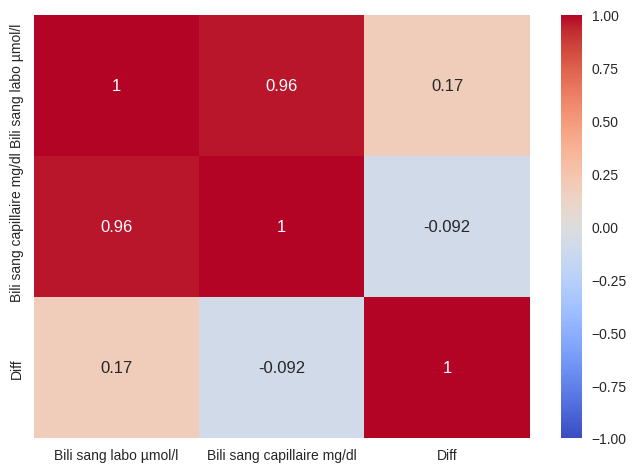

In [336]:
#correlation between the 2 features
sns.heatmap(df2.corr(), annot=True, vmin=-1, vmax=1, annot_kws={'size': 12}, cmap='coolwarm')

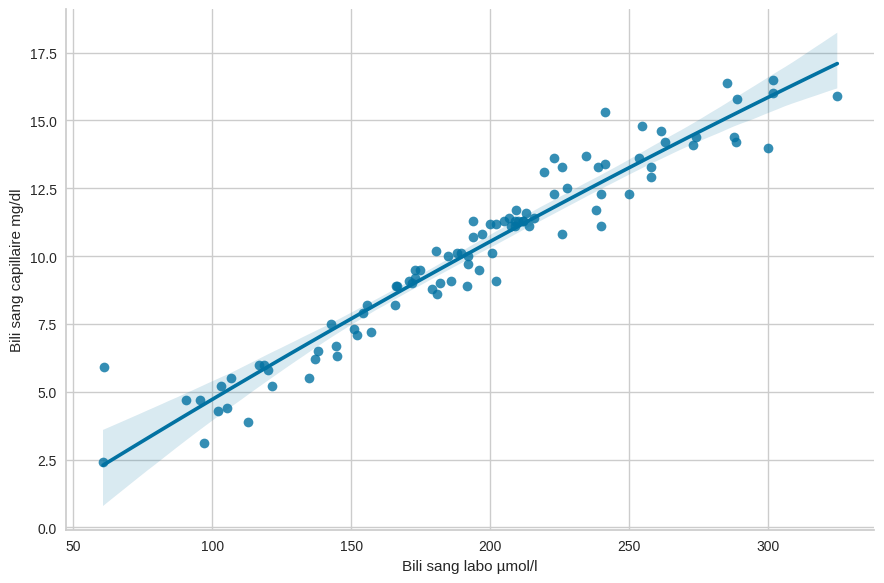

In [337]:
# linear regression between bili sang labo and bili sang capillaire
sns.lmplot(x='Bili sang labo µmol/l', y='Bili sang capillaire mg/dl', data=df2, height=6, aspect=1.5, order = 2)

In [340]:
# identify how many patients had more than 10µmol/l difference between bili sang capillaire and bili sang labo
df2_10 = df2[abs(df2['Bili sang labo µmol/l'] - 17.1*df2['Bili sang capillaire mg/dl']) > 10]
df2_10.shape

(84, 3)

In [341]:
# identify how many patients had more than 20µmol/l difference between bili sang capillaire and bili sang labo
df2_20 = df2[abs(df2['Bili sang labo µmol/l'] - 17.1*df2['Bili sang capillaire mg/dl']) >= 20]
df2_20.shape

(45, 3)

In [342]:
#percentage of difference >20
np.round((df2_20.shape[0]) / df2.shape[0] * 100, 1)

47.9

We identified 48% of patients with a difference above 20

In [343]:
#  identify how many patients had more than 10µmol/l and less than 20 difference between bili sang capillaire and bili sang labo
df2_10_20 = df2[(abs(df2['Bili sang labo µmol/l'] - 17.1*df2['Bili sang capillaire mg/dl']) > 10) &
             (abs(df2['Bili sang labo µmol/l'] - 17.1*df2['Bili sang capillaire mg/dl']) < 20)]
df2_10_20.shape

(39, 3)

In [344]:
# # identify how many patients had more than 30µmol/l difference between bili sang capillaire and bili sang labo
df2_30 = df2[abs(df2['Bili sang labo µmol/l'] - 17.1*df2['Bili sang capillaire mg/dl']) >= 30]
df2_30.shape

(26, 3)

In [345]:
#percentage of difference >30
np.round((df2_30.shape[0]) / df2.shape[0] * 100, 1)

27.7

We identified 28% of patients with a difference above 30

In [346]:
# create new column in df3 with bins refeclecting difference between Bili capillaire an Bili labo
bins = [0, 10, 20, 30, 40,100]
labels = ['0-10', '10-20', '20-30', '30-40', '>40']
df2['Bin_Diff'] = pd.cut(df2['Bili sang labo µmol/l'] - 17.1*df2['Bili sang capillaire mg/dl'], bins=bins, labels=labels)
df2.head()


,Bili sang labo µmol/l,Bili sang capillaire mg/dl,Diff,Bin_Diff
0,106.90,5.5,7.882353,10-20
1,142.80,7.5,9.000000,10-20
2,285.26,16.4,3.800000,0-10
3,241.40,13.4,8.000000,10-20
4,262.99,14.2,12.700000,20-30


<Axes: xlabel='Bin_Diff'>

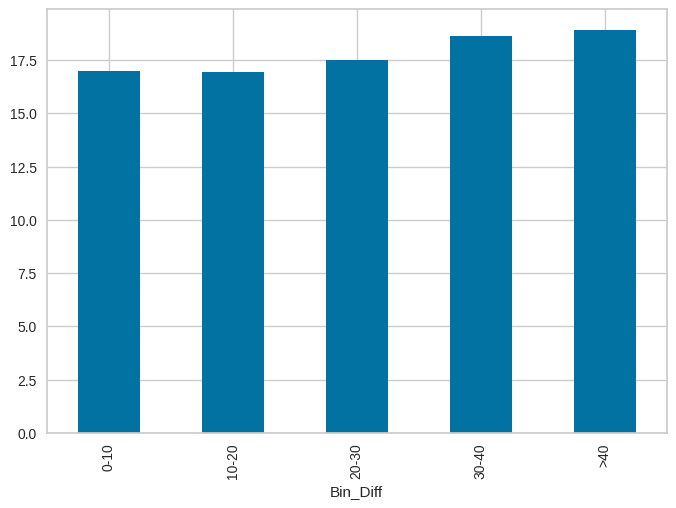

In [347]:
# Some units report that higher Hb is correlated with more error from the cap bili....
# Convert 'Hb (g/dl' column to numeric, handling non-numeric values
df2['Hb (g/dl'] = pd.to_numeric(df1['Hb (g/dl'], errors='coerce')
# creat graph showing bins in abcisse and mean Hb as y axis
df2.groupby('Bin_Diff')['Hb (g/dl'].mean().plot(kind='bar')


There is a trend showing that higher Hb is correlated with higher differences between lab and capillary bilirubin

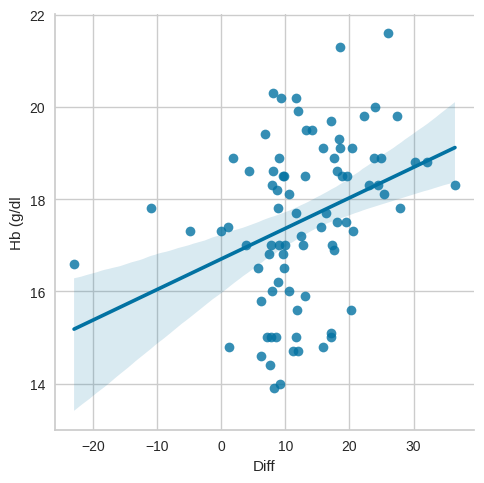

In [348]:
#scatterplot with abcisse Diff_value and y axis Hb
sns.lmplot(x='Diff', y='Hb (g/dl', data=df2)

However, there a great spread of the data far from the regression line. Hb will thus not interfere with our interpretation of bilirubin instantaneous value.

<Axes: >

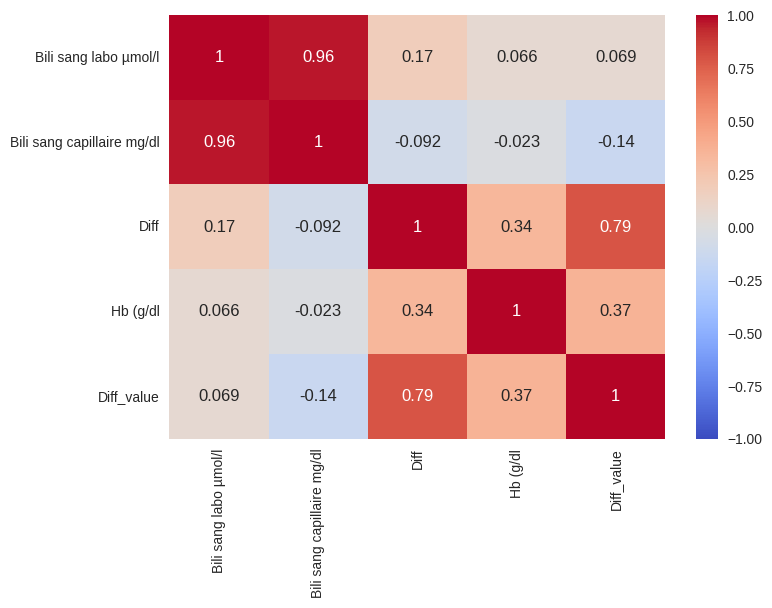

In [349]:
# correlation map between features
# Convert 'Diff' column to a numerical representation
df2['Diff_value'] = np.round(abs(17.1*df2['Bili sang capillaire mg/dl']- df2['Bili sang labo µmol/l']),1)

# Calculate correlation matrix excluding non-numerical columns
correlation_matrix = df2.select_dtypes(include=['number']).corr()

# Show correlation heatmap
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, annot_kws={'size': 12}, cmap='coolwarm')

Bili cap and bili lab are highly correlated as previously suggested. There is come correlation between the differences and HB level but this can not be used individually as there is a great variance of the results

In [350]:
df2['Diff_value'] = np.round(abs(17.1*df2['Bili sang capillaire mg/dl']- df2['Bili sang labo µmol/l']),1)
df2.head()

,Bili sang labo µmol/l,Bili sang capillaire mg/dl,Diff,Bin_Diff,Hb (g/dl,Diff_value
0,106.90,5.5,7.882353,10-20,16.0,12.8
1,142.80,7.5,9.000000,10-20,17.0,14.6
2,285.26,16.4,3.800000,0-10,17.0,4.8
3,241.40,13.4,8.000000,10-20,20.3,12.3
4,262.99,14.2,12.700000,20-30,17.0,20.2


In [351]:
#how frequent it is that bili capillaire is more than Bili sang labo
np.round(df2[df2['Bili sang labo µmol/l'] < 17.1*df2['Bili sang capillaire mg/dl']].shape[0] / df2.shape[0],2)

0.05

In 5% of the cases only, bili capillaire is more than bili sang labo

In [352]:
# when difference between bili capillaire and Bili labo is >20 how often is it that bili capillaire is above bili sang
np.round(df2[(df2['Bili sang labo µmol/l'] < 17.1*df2['Bili sang capillaire mg/dl']) & (df2['Diff_value'] > 20)].shape[0] / df2.shape[0],2)

0.02


For extreme difference values > 20, in 98% of cases lab bilirubin is above instantaneous bilirubin


 As a conclusion, we should asume that most of the time, bili capillaire is below bili sang labo

In [353]:
# Creating a prediction model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming your data is in a DataFrame called 'df3'
X = df2[['Bili sang capillaire mg/dl']]
y = df2['Bili sang labo µmol/l']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)

Root Mean Squared Error: 18.038732006413404
Mean Squared Error: 325.3958523992034


In [354]:
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])

Intercept: 22.695288073226322
Coefficient: 16.805679756687248


So the linear model is:
Bili sang labo (µmol/l) = bili capillaire (mg/dl) x 17 + 23

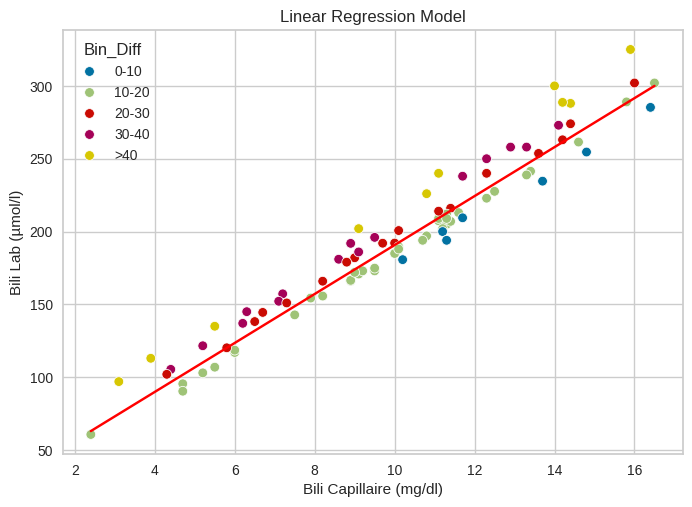

In [355]:
# Scatter plot of the original data
sns.scatterplot(x='Bili sang capillaire mg/dl', y='Bili sang labo µmol/l', data=df2, hue = 'Bin_Diff')

# Generate points for the regression line
x_range = np.linspace(df2['Bili sang capillaire mg/dl'].min(), df2['Bili sang capillaire mg/dl'].max(), 100)
y_pred_line = model.intercept_ + model.coef_[0] * x_range

# Plot the regression line
plt.plot(x_range, y_pred_line, color='red')

plt.xlabel('Bili Capillaire (mg/dl)')
plt.ylabel('Bili Lab (µmol/l)')
plt.title('Linear Regression Model')
plt.show()

In [356]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming you have X_test, y_test from your previous code
# Assuming your data is in a DataFrame called 'df3'
X = df2[['Bili sang capillaire mg/dl']]
y = df2['Bili sang labo µmol/l']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Create and Fit Quadratic Model ---
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)  # Transform training data for polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)  # Fit the model on transformed data

# --- Quadratic Model RMSE ---
y_pred_poly = model_poly.predict(poly.transform(X_test))
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
print("RMSE of Quadratic Model:", rmse_poly)

# --- Simple Model RMSE ---
# Access the 'Bili sang capillaire mg/l' column from the original df3 DataFrame, using the index of X_test to select the corresponding rows.
for i in range (20,30):
  y_pred_simple = 17*df2.loc[X_test.index, 'Bili sang capillaire mg/dl'] + i
  rmse_simple = np.sqrt(mean_squared_error(y_test, y_pred_simple))
  print("RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + {}):".format(i), rmse_simple)

RMSE of Quadratic Model: 17.94411587039923
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 20): 18.467051598369515
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 21): 18.085219175657755
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 22): 17.75157205788591
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 23): 17.468871412345234
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 24): 17.239623728950395
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 25): 17.065983247692653
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 26): 16.94965905572331
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 27): 16.891835305851163
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 28): 16.893112735512563
RMSE of Simple Model (Bili Labo = 17*Bili Capillaire + 29): 16.95347798504701


In [357]:
print("Intercept:", model_poly.intercept_)
print("Coefficient:", model_poly.coef_)

Intercept: 25.58356928479418
Coefficient: [ 0.         16.17844688  0.03088432]


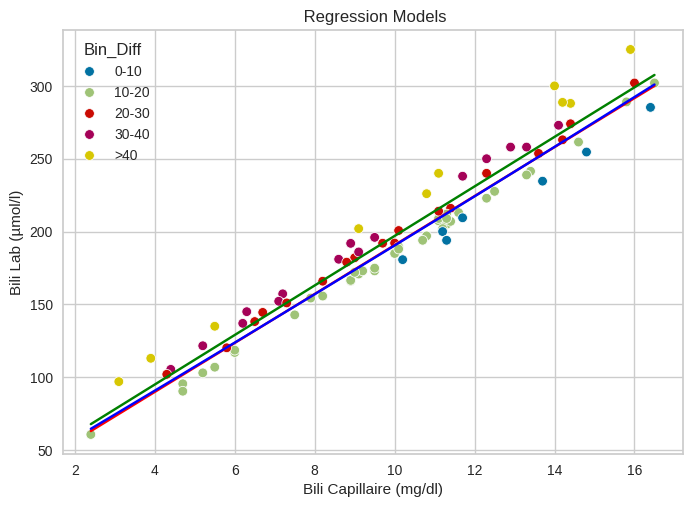

In [358]:
# Scatter plot of the original data
sns.scatterplot(x='Bili sang capillaire mg/dl', y='Bili sang labo µmol/l', data=df2, hue = 'Bin_Diff')

# Generate points for the regression line
x_range = np.linspace(df2['Bili sang capillaire mg/dl'].min(), df2['Bili sang capillaire mg/dl'].max(), 100)
y_pred_line = model.intercept_ + model.coef_[0] * x_range

# Plot the regression line
plt.plot(x_range, y_pred_line, color='red')


# quadratic model
# Generate predictions for the quadratic model across the full x_range
x_range_poly = poly.transform(x_range.reshape(-1, 1))  # Transform x_range for polynomial features
y_pred_poly_full = model_poly.predict(x_range_poly)  # Predict for the entire range
plt.plot(x_range, y_pred_poly_full, color='blue')  # Plot the quadratic model


# simple model
# Recalculate y_pred_simple for the full x_range (assuming you want to use the best 'i' from previous calculations)
best_i = 27
y_pred_simple = 17 * x_range + best_i
plt.plot(x_range, y_pred_simple, color='green')  # Now plot with the full range

plt.xlabel('Bili Capillaire (mg/dl)')
plt.ylabel('Bili Lab (µmol/l)')
plt.title(' Regression Models')

plt.show()

In [382]:
import plotly.express as px
from sklearn.linear_model import LinearRegression

# Assuming you have a DataFrame 'df'
# Replace 'x_col' and 'y_col' with the actual column names from your DataFrame
x = df['Bili sang labo µmol/l']
y = df['Bili sang capillaire mg/dl']

# Reshape the data for the LinearRegression model
x = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# --- Use X_test to calculate y_pred for RMSE ---
y_pred_rmse = coefficient * X_test + intercept  # Use X_test for RMSE calculation

# Create the Plotly Express figure with trendline
fig = px.scatter(df, x='Bili sang capillaire mg/dl', y='Bili sang labo µmol/l',
                 trendline="ols")

# Access the regression results (this part is a bit more involved with Plotly)
results = px.get_trendline_results(fig)
intercept = results.iloc[0]["px_fit_results"].params[0]
coefficient = results.iloc[0]["px_fit_results"].params[1]

# Print the intercept and coefficients
print("Intercept:", intercept)
print("Coefficient:", coefficient)
print("R-squared:", model.score(x, y))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rmse)))

fig.show()

Intercept: 25.004302995072955
Coefficient: 16.688972470229626
R-squared: 0.9319306572762167
RMSE: 17.593312544502748


In [401]:
import plotly.express as px
import numpy as np

# Assuming you want to use df2 and the same x and y variables as before
x_col = 'Bili sang capillaire mg/dl'
y_col = 'Bili sang labo µmol/l'

# Given intercept and coefficient
intercept = 27
coefficient = 17

# --- Use X_test to calculate y_pred for RMSE ---
y_pred_rmse = coefficient * X_test + intercept  # Use X_test for RMSE calculation


# Generate x_range for the line
x_range = np.linspace(df2[x_col].min(), df2[x_col].max(), 100)
y_pred = coefficient * x_range + intercept  # Calculate y values using the linear equation

# Create the Plotly Express figure with scatter plot
fig = px.scatter(df2, x=x_col, y=y_col,
                 title="Linear Model with Plotly Express")

# Add the linear model line
fig.add_scatter(x=x_range, y=y_pred, mode='lines', name='Linear Model',
                line=dict(color='red'))

print("Intercept:", intercept)
print("Coefficient:", coefficient)
print("R-squared:", model.score(x, y))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rmse)))


fig.show()

Intercept: 27
Coefficient: 17
R-squared: 0.9319306572762167
RMSE: 16.891835305851163


In [410]:
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you want to use df2 and the same x and y variables as before
x_col = 'Bili sang capillaire mg/dl'
y_col = 'Bili sang labo µmol/l'

# Given intercept and coefficient
intercept = 27
coefficient = 17

# --- Use X_test to calculate y_pred for RMSE ---
y_pred_rmse = coefficient * X_test + intercept  # Use X_test for RMSE calculation

# Generate x_range for the line (for visualization)
x_range = np.linspace(df2[x_col].min(), df2[x_col].max(), 100)
y_pred = coefficient * x_range + intercept  # Calculate y values using the linear equation

# Create the Plotly Express figure with scatter plot
fig = px.scatter()


# Add the linear model line
fig.add_scatter(x=x_range, y=y_pred, mode='lines', name='Linear Model',
                line=dict(color='red'))
fig.update_layout(
    title='Correlation entre la Bilirubine instantanee (mg/dl) et la Bilirubine sang labo (micromoles/l)',
    xaxis_title='Bilirubine instantanee (mg/dl)',
    yaxis_title='Bilirubine sang labo (micromoles/l)',
    xaxis_tickformat=".2f",  # Format x-axis tick labels to 2 decimal places
    yaxis_tickformat=".2f"   # Format y-axis tick labels to 2 decimal places
)



print("Intercept:", intercept)
print("Coefficient:", coefficient)
print("R-squared:", model.score(x, y))  # Assuming 'model', 'x', and 'y' are still defined from previous cells
# --- Calculate RMSE using y_pred_rmse ---
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rmse)))

fig.show()


Intercept: 27
Coefficient: 17
R-squared: 0.9319306572762167
RMSE: 16.891835305851163


In [411]:
import plotly.io as pio

pio.write_html(fig, file='/content/drive/MyDrive/Bilirubine/my_graph.html', auto_open=True)

In [393]:
import os
print(os.getcwd())

/content


In [385]:
!pip install ipywidgets

import plotly.graph_objects as go
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Given intercept and coefficient
intercept = 27
coefficient = 17

# Generate x_range for the line (for visualization)
x_range = np.linspace(0, 20, 100)  # Adjust the range as needed
y_pred = coefficient * x_range + intercept

# Create the Plotly figure
fig = go.Figure(data=[go.Scatter(x=x_range, y=y_pred, mode='lines', name='Linear Model')])

# Create input widget for Bili capillaire
bili_capillaire_input = widgets.FloatText(
    value=5,
    description='Bili capillaire:',
    disabled=False
)

# Create output widget to display Bili sang labo
bili_labo_output = widgets.Label()

# Define function to update Bili sang labo based on input
def update_bili_labo(change):
    bili_capillaire = change.new
    bili_labo = coefficient * bili_capillaire + intercept
    bili_labo_output.value = f'Bili sang labo: {bili_labo:.2f}'

# Register the update function with the input widget
bili_capillaire_input.observe(update_bili_labo, names='value')

# Display the widgets and the plot
display(bili_capillaire_input, bili_labo_output)
fig.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.2 MB/s eta 0:00:00


FloatText(value=5.0, description='Bili capillaire:')

Label(value='')

In [386]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [387]:
streamlit hello

SyntaxError: invalid syntax (<ipython-input-387-c7a1b683aa76>, line 1)

So 3 models have been tested:

**Linear model: Y = 16.8 * X +22.7**,     rmse = 18.0

**Quadratic model: Y= 25.5 + 16.7* X + 0.03 Xsqr2**,    rmse = 17.9

**Simplified model: Y = 17 * X + 27**,     rmse = 18.891

The best model is thus the linear model, but is too complicated for routine use with the float values as intercept and coefficient.

I have thus choosen the **simplified model**
